In [ ]:
from IPython.display import Image

In [ ]:
#!pip install wandb

In [3]:
from __future__ import print_function
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

In [4]:
# Set random seed for reproducibility
manualSeed = 121
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  121


In [5]:
import torch.autograd as autograd
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import ImageFolder

In [6]:
import wandb

In [7]:
wandb.login()

wandb: Currently logged in as: anzovi (anzovitte). Use `wandb login --relogin` to force relogin


True

# Через conv2d(kernl = 1) и conv2d(kernl = 3) в split 2

In [8]:
# Дирректория с изображениями
#dataroot = "C:\\Users\\Sky\\EveryPixel\\Project_Edu\\img_align_celeba"
dataroot = "C:/Users/Andrej/1_GAN_2/img_align_celeba"
# Количество воркеров для сборки датасета
workers = 2

# Размер батча
batch_size = 128*2

# Размер входа сети для изображений. Все изображения ресайзятся к нему
image_size = 128

# Количество каналов цвета
nc = 3

# Размер латентного вектора (размерность латентного пространства)
nz = 100

# Size of feature maps in generator
ngf = 128

# Рамер карты признаков для генератора
ndf = 128

# Кол-во эпох
num_epochs = 5

# Лернингрейт
lr = 0.0002

# Параметр для оптимизатора Adam
beta1 = 0.9

# Количество GPU, 0 если считаем на CPU
ngpu = 1

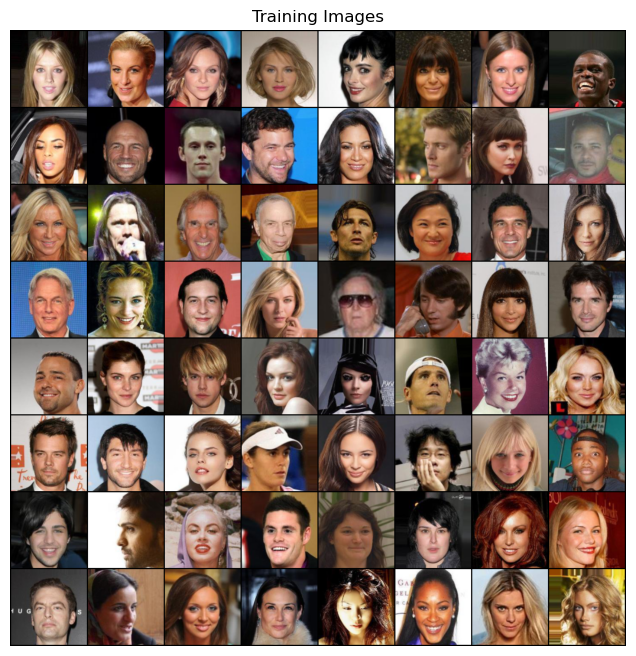

In [9]:
# Для создания датасета используем класс ImageFolder
# Создаем датасет
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
# Создаем даталоадер
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

# Выбираем девайс для вычислений
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Нарисуем часть картинок из датасета
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [10]:
# кастомная инициализация весов netG или netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [11]:
class CSPupBlock(nn.Module):
    def __init__(self, npf):
        super(CSPupBlock, self).__init__()
        #Aux
        ## При учете если npf = 256
        #self.deconv = nn.ConvTranspose2d( 100, npf*2, 8, 1, 0, bias=False) # shape (1,100, 1, 1) -> (1,1024, 8, 8)
        
        self.deconv = nn.ConvTranspose2d( nz, npf, 8, 1, 0, bias=False) # shape (1,100, 1, 1) -> (1,1024, 4, 4)
        self.norm = nn.BatchNorm2d(npf)
        #self.rel = nn.LeakyReLU(0.2, inplace=True)
        self.rel = nn.ReLU(True)
        
        #Split 1
        self.upsample0_0 = nn.ConvTranspose2d(npf, npf, kernel_size = 4,stride = 2, padding = 1, bias=False)
        #self.norm0_0 = nn.InstanceNorm2d(npf)
        self.norm0_0 = nn.BatchNorm2d(npf)
        
        
        #Split 2
        self.conv1d0_1 = nn.Conv2d(npf, npf,kernel_size = 1, stride=1, padding = 0, bias=False)
        #self.norm0_1= nn.InstanceNorm1d(npf)
        self.norm0_1= nn.BatchNorm2d(npf)
        
        self.relu0_1 = nn.LeakyReLU(0.2, inplace=True)
        #self.relu0_1 = nn.ReLU(True),
        
        self.upsample1_1 = nn.ConvTranspose2d(npf, npf, kernel_size = 4,stride = 2, padding = 1, bias=False)
        #self.norm1_1 = nn.InstanceNorm2d(npf)
        self.norm1_1 = nn.BatchNorm2d(npf)
        
        self.conv3d0_1 = nn.Conv2d(npf, npf, kernel_size = 3, stride=1, padding = 1, bias=False)
        #self.norm2_1 = nn.InstanceNorm3d(npf)
        self.norm2_1 = nn.BatchNorm2d(npf)
        
        self.relu1_1 = nn.LeakyReLU(0.2, inplace=True)
        #self.relu1_1 = nn.ReLU(True),
        
        self.conv3d1_1 = nn.Conv2d(npf, npf, kernel_size = 3, stride=1, padding = 1, bias=False)
        #self.norm3_1 = nn.InstanceNorm3d(npf)
        self.norm3_1 = nn.BatchNorm2d(npf)

    def forward(self,x):
        B_num, Ch, H, W = x.size()
        #print(B_num, Ch, H, W)
        
        if (H == 1 and W == 1):
            #Так как по видео памяти не вытягивает машина - скипнули блок с глубиной 1024, начинаем с npf = 512
            ## shape (1,100, 1, 1) -> (1,512, 8, 8)
            x = self.deconv(x)
            x = self.norm(x)
            x = self.rel(x)
            #B_num, Ch, H, W = x.size()
            #print(x.size())
            return x
        else:
            #shape (1,512, 8, 4) -> (1,256, 8, 8) , (1,256, 8, 8)
            x_1, x_2 = x[:,Ch//2:,:,:] , x[:,:Ch//2,:,:]
    
            #Split 1
            #Upsample
            ## shape (1,256, 8, 8) -> (1,256, 16, 16)
            x_1 = self.upsample0_0(x_1)
            x_1 = self.norm0_0(x_1)
    
    
            #Split 2
            
            #Conv1
            x_2 = self.conv1d0_1(x_2)
            x_2 = self.norm0_1(x_2)
    
            #Relu
            x_2 = self.relu0_1(x_2)
    

            ## shape (1,256, 4, 4) -> (1,256, 8, 8)
            # Upsample
            x_2 = self.upsample1_1(x_2)
            x_2 = self.norm1_1(x_2)
    
    
            #conv3
            x_2 = self.conv3d0_1(x_2)
            x_2 = self.norm2_1(x_2)
            #Relu
            x_2 = self.relu1_1(x_2)
            #conv3
            x_2 = self.conv3d1_1(x_2)
            x_2 = self.norm3_1(x_2)

        
            return x_1 + x_2
        

In [12]:
# Имплементация генератора
# Генерируем батч латентных векторов
        #noise = torch.randn(b_size, nz, 1, 1, device=device)
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # вход Z, идет в convolution

            # state size. (100) x 1 x 1
            
            CSPupBlock(512),
            # state size. (512) x 8 x 8
            #nn.Dropout(p=0.2),

            CSPupBlock(512//(2**1)),
            #nn.Dropout(p=0.2),
            # state size. (256) x 16 x 16
            
            CSPupBlock(512//(2**2)),
            #nn.Dropout(p=0.2),
            # state size. (128) x 32 x 32
            
            CSPupBlock(512//(2**3)),
            #nn.Dropout(p=0.2),
            # state size. (64) x 64 x 64
            nn.ConvTranspose2d(64, 3, kernel_size = 4,stride = 2, padding = 1, bias=False),
            #nn.BatchNorm2d(3),
            #nn.ReLU(True)
            nn.Tanh()
            # state size. (3) x 128 x 128

        )

    def forward(self, input):
        return self.main(input)

In [13]:
# Инициализируем генератор
netG = Generator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Инициализируем веса
netG.apply(weights_init)

print(netG)

Generator(
  (main): Sequential(
    (0): CSPupBlock(
      (deconv): ConvTranspose2d(100, 512, kernel_size=(8, 8), stride=(1, 1), bias=False)
      (norm): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (rel): ReLU(inplace=True)
      (upsample0_0): ConvTranspose2d(512, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (norm0_0): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1d0_1): Conv2d(512, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (norm0_1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0_1): LeakyReLU(negative_slope=0.2, inplace=True)
      (upsample1_1): ConvTranspose2d(512, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (norm1_1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3d0_1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), p

In [14]:
# # Имплементация дискриминатора
"""
Одна из первых версий, простая, с добавлением слоя-пустышки, для усложнения архитектуры:
            nn.Conv2d(ndf * 4, ndf * 4, kernel_size = 3, stride=1, padding = 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
"""
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc)((3)) x 128 x 128
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf)((128)) x 64 x 64
            
            nn.Conv2d(ndf, ndf*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf*2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf)((128)) x 32 x 32
            
            nn.Conv2d(ndf*2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2)((256)) x 16 x 16
            
            nn.Conv2d(ndf * 4, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4)((512)) x 8 x 8

            ##in_ch, out_ch, kern, stride, padding
            nn.Conv2d(ndf * 4, 1, 8, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        #Print()
        return self.main(input)

In [15]:
# инициализируем дискриминатор
netD = Discriminator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Инициализируем веса
netD.apply(weights_init)

print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2, inplace=True)
    (9): Conv2d(512, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=0.2, inplace=True)
    (12): Conv2d(512, 1, kernel_siz

# Обучение

In [16]:
# Инициализируем лосс
criterion = nn.BCELoss()

# Создаем батч с рандомным шумом для генерации
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Метки для реальных данных и фековых
real_label = 1.
fake_label = 0.

# Устанавливаем оптимизаторы для G и D
"""
### Регуляция lr -> если маленький, то генератор быстро переигрывает дискриминатор, и лос дискриминатора улетает вверх, 
большой lr -> дискриминатор быстро обучается до loss < 0.5 и лосс генератора начинает увеличиваться
"""
optimizerD = optim.SGD(netD.parameters(), lr=lr*2.0)#2.1 № 1.9####1.7####
#optimizerD = optim.Adam(netD.parameters(), lr=lr*1, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr*0.01, betas=(beta1, 0.999))#1.5####1.7

In [21]:
torch.cuda.empty_cache()

In [22]:
torch.cuda.is_available()

True

In [23]:
run = wandb.init(project="DCGAN_ResConv")

In [24]:
config = run.config

In [25]:
run.watch(netD)

In [26]:
run.watch(netG)

# Попытка достичь сходимости с градиентным штрафом
Увы, упор в память

In [27]:
%%time 

img_list = []
G_losses = []
D_losses = []
iters = 0
p_coeff = 10 # lambda

D_labels = torch.ones([batch_size]).to(device) # Discriminator Label to real
D_fakes = torch.zeros([batch_size, 1]).to(device) # Discriminator Label to fake

print("Starting Training Loop...")
# Для каждой эпохи
for epoch in range(num_epochs):
    # Для каждого батча
    for i, data in enumerate(dataloader, 0):

        ############################
        # (1) Учим дискриминатор: максимизируем log(D(x)) + log(1 - D(G(z)))
        ###########################
        
        ## Train with all-real batch
        netD.zero_grad()
        # Для батча
        real_cpu = data[0].to(device)

        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Прямой прогон батча из реальных картинок D
        output = netD(real_cpu).view(-1)

        # Считаем лосс на всем батче реальных картинок

        errD_real = criterion(output, label)
        # Вычисляем градиенты для дискриминатора


        D_x = output.mean().item()
    
        ## Учим на полном фейковом батче
        # Генерируем бат латентных векторов
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Генерируем фековый батч с помощью G
        fake = netG(noise)

        # Gradient Penalty (e.g. gradients w.r.t x_penalty)
        eps = torch.rand(b_size, 1, 1, 1).to(device) # x shape: (64, 1, 28, 28)

        x_penalty = eps*real_cpu + (1-eps)*fake

        p_outputs = netD(x_penalty).view(-1)
        xp_grad = autograd.grad(outputs=p_outputs, inputs=x_penalty, grad_outputs=D_labels,
                                create_graph=True,retain_graph=True, only_inputs=True) #retain_graph=True
        grad_penalty = p_coeff * torch.mean(torch.pow(torch.norm(xp_grad[0], 2, 1) - 1, 2))
        
        label.fill_(fake_label)
        # Классифицируем фековый батч с помощью D
        output = netD(fake.detach()).view(-1)
        # Вычисляем лосс дискриминатора на фейковом батче
        
        
        errD_fake = criterion(output, label) #+ grad_penalty
        # Вычисляем градиент для фейкового батча, он суммируется с предидущим
        #if (iters > 1 and 20*errG.item() < errD.item()):
        errD_fake.backward()#retain_graph=True
        D_G_z1 = output.mean().item()
        # Вычисляем ошибку на реальном и фековом батчах
        errD = errD_real + errD_fake# + grad_penalty

        # Обновляем веса D
        optimizerD.step()

        
        for p in netD.parameters():
            p.data.clamp_(-0.05, 0.05)#0.05
        
        #if iters % 2 == 0:
        netG.zero_grad()
        label.fill_(real_label)  # для генератора фейковые метки есть реальные (0 меняем на 1)
        # Так как мы обновили веса дискриминатора прогоним фековый батч через него еще  раз
        output = netD(fake).view(-1)
        # Вычислим лосс G основываясь на выходе D

        errG = criterion(output, label)
        # Вычислим градиент для G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Обновляем веса G
        optimizerG.step()
    
        # Выводим статистику обучения
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Сохраним лоссы
        G_losses.append(errG.item())
        D_losses.append(errD.item())
        run.log({"lossD": errD})
        run.log({"lossG": errG})

        # Проверим какие картинки рисует генератор
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...
[0/5][0/792]	Loss_D: 2.1392	Loss_G: 0.7341	D(x): 0.5230	D(G(z)): 0.5170 / 0.4806


OutOfMemoryError: CUDA out of memory. Tried to allocate 512.00 MiB. GPU 0 has a total capacity of 8.00 GiB of which 0 bytes is free. Of the allocated memory 14.20 GiB is allocated by PyTorch, and 189.46 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

# Вывод

К сожалению не хватает видео памяти для такого обучения, подозреваю что это бы помогло решить проблему mode collapse